# **OVERVIEW**

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.


Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.


While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

# **DATA**

`application_{train|test}.csv`

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

`bureau.csv`

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

`bureau_balance.csv`

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.
POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

`credit_card_balance.csv`

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

`previous_application.csv`

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

`installments_payments.csv`

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

`HomeCredit_columns_description.csv`

This file contains descriptions for the columns in the various data files.

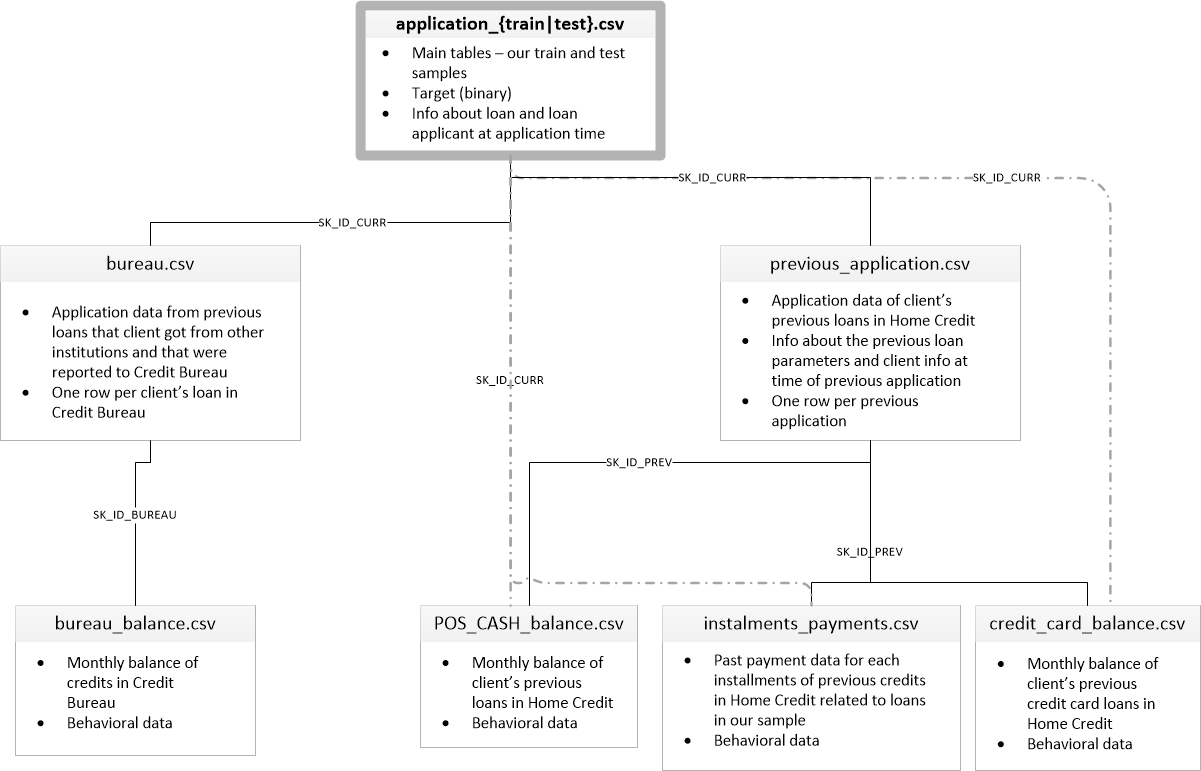)

As seen in Figure 1, the file application_{train|test}.csv contains the main table containing the training dataset (307511 samples) and test dataset (48744 samples), with each row representing one loan identified by the feature SK_ID_CURR. 

The training set contains the variable TARGET with binary values 
(
  0: the loan was repaid or 
  1: the loan was not repaid
). 

There are many input files available, which will be analysed for input features to train the model. The large number of input features and training samples will allow me to identify the important factors and for constructing a credit default risk classification model.

# **PROBLEM STATEMENT**

The problem and associated data has been provided by Home Call Credit Group for a Kaggle competition. The problem can be described as, “A binary classification problem where the inputs are various features describing the financial and behavioral history of the loan applicants, in order to predict whether the loan will be repaid or defaulted.”

# **Project Novelty**
The notebook provides a complete end-to-end workflow for building a binary classifier, and includes methods like automated feature engineering for connecting relational databases, comparison of different classifiers on imbalanced data, and hyperparameter tuning using Bayesian optimization.

# **Project Design and Solution**

**The project has been divided into five parts-**

`Data Preparation` - Before starting the modeling, we need to import the necessary libraries and the datasets. If there are more than one files, then all need to be imported before we can look at the feature types and number of rows/columns in each file.

`Exploratory Data Analysis` - After data importing, we can investigate the data and answer questions like- How many features are present and how are they interlinked? What is the data quality, are there missing values? What are the different data types, are there many categorical features? Is the data imbalanced? And most importantly, are there any obvious patterns between the predictor and response features?

`Feature Engineering` - After exploring the data distributions, we can conduct feature engineering to prepare the data for model training. This includes operations like replacing outliers, imputing missing values, one-hot encoding categorical variables, and rescaling the data. Since there are number of relational databases, we can use extract, transform, load (ETL) processes using automated feature Engineering with Featuretools to connect the datasets. The additional features from these datasets will help improve the results over the base case (logistic regression).

`Classifier Models`: Training, Prediction and Comparison - After the dataset is split into training and testing sets, we can correct the data imbalances by undersampling the majority class. Then, we can training the different classifier models (Logistic Regression, Random Forest, Decision Tree, Gaussian Naive Bayes, XGBoost, Gradient Boosting, LightGBM) and compare their performance on the test data using metrics like accuracy, F1-score and ROC AUC. After choosing the best classifier, we can use K-fold cross validation to select the best model. This will help us choose parameters that correspond to the best performance without creating a separate validation dataset.

`Hyperparameter Tuning` - After choosing the binary classifier, we can tune the hyperparameters for improving the model results through grid search, random search, and Bayesian optimization (Hypertopt library). The hyperparameter tuning process will use an objective function on the given domain space, and an optimization algorithm to give the results. The ROC AUC validation scores from all three methods for different iterations can be compared to see trends.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
bureau = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bureau_10k.csv")
bureau_balance = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bureau_balance_10k.csv")
credit_card_balance = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/credit_card_balance_10k.csv")
installments_payments = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/installments_payments_10k.csv")
pos_cash_balance = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/pos_cash_balance_10k.csv")
previous_application = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/previous_application_10k.csv")

In [13]:
application_train_25k = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/application_train_25k.csv")

In [8]:
bureau.head()

,Unnamed: 0,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [7]:
bureau_balance.head()

,Unnamed: 0,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,0,5715448,0,C
1,1,5715448,-1,C
2,2,5715448,-2,C
3,3,5715448,-3,C
4,4,5715448,-4,C


In [9]:
credit_card_balance.head()

,Unnamed: 0,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [10]:
installments_payments.head()

,Unnamed: 0,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [11]:
pos_cash_balance.head()

,Unnamed: 0,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1,1715348,367990,-33,36.0,35.0,Active,0,0
2,2,1784872,397406,-32,12.0,9.0,Active,0,0
3,3,1903291,269225,-35,48.0,42.0,Active,0,0
4,4,2341044,334279,-35,36.0,35.0,Active,0,0


In [12]:
previous_application.head()

,Unnamed: 0,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
application_train_25k.head()

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
application_train_25k.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 123 columns):
 #    Column                        Non-Null Count  Dtype  
---   ------                        --------------  -----  
 0    Unnamed: 0                    25000 non-null  int64  
 1    SK_ID_CURR                    25000 non-null  int64  
 2    TARGET                        25000 non-null  int64  
 3    NAME_CONTRACT_TYPE            25000 non-null  object 
 4    CODE_GENDER                   25000 non-null  object 
 5    FLAG_OWN_CAR                  25000 non-null  object 
 6    FLAG_OWN_REALTY               25000 non-null  object 
 7    CNT_CHILDREN                  25000 non-null  int64  
 8    AMT_INCOME_TOTAL              25000 non-null  float64
 9    AMT_CREDIT                    25000 non-null  float64
 10   AMT_ANNUITY                   25000 non-null  float64
 11   AMT_GOODS_PRICE               24982 non-null  float64
 12   NAME_TYPE_SUITE               24897 non-null

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


float (65)
int (42)
object(16)

TARGET - is the label we want to predict

In [25]:
application_train_25k.shape

(25000, 123)

In [30]:
#@title TARGET column distribution
application_train_25k.TARGET.value_counts()

0    23004
1     1996
Name: TARGET, dtype: int64

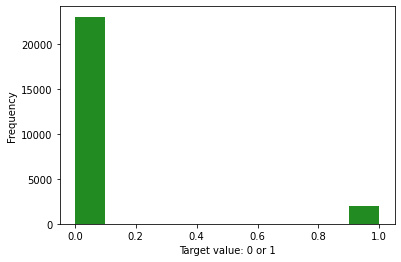

In [31]:
application_train_25k['TARGET'].astype(int).plot.hist(color='forestgreen').set_xlabel('Target value: 0 or 1');

Data is imbalanced

(0.0, 100.0)

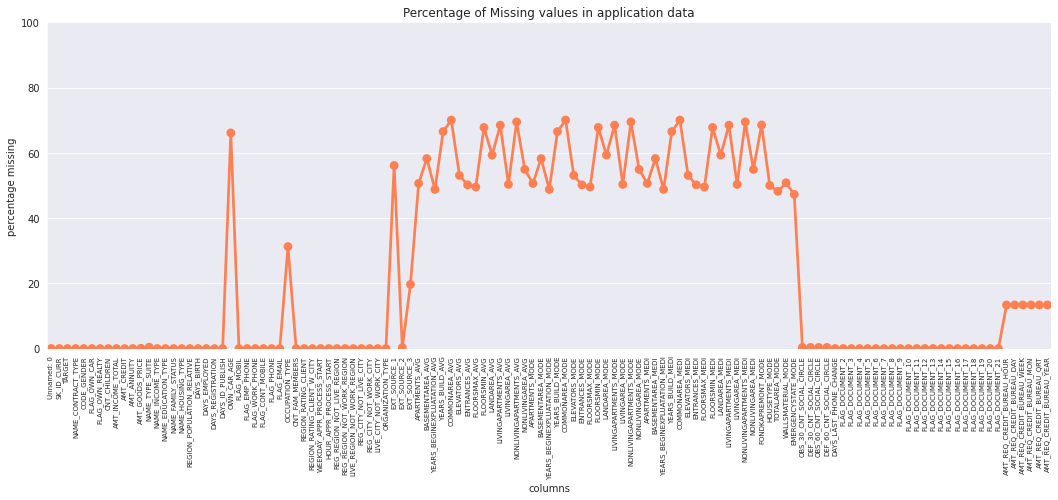

In [36]:
fig = plt.figure(figsize=(18,6))
miss_data = pd.DataFrame((application_train_25k.isnull().sum())*100/application_train_25k.shape[0]).reset_index()
miss_data["type"] = "application data"
sns.set_style('darkgrid')
ax = sns.pointplot("index",0,data=miss_data, color='coral')
plt.xticks(rotation =90,fontsize =7)
plt.title("Percentage of Missing values in application data")
plt.ylabel("percentage missing")
plt.xlabel("columns")
plt.ylim((0,100))

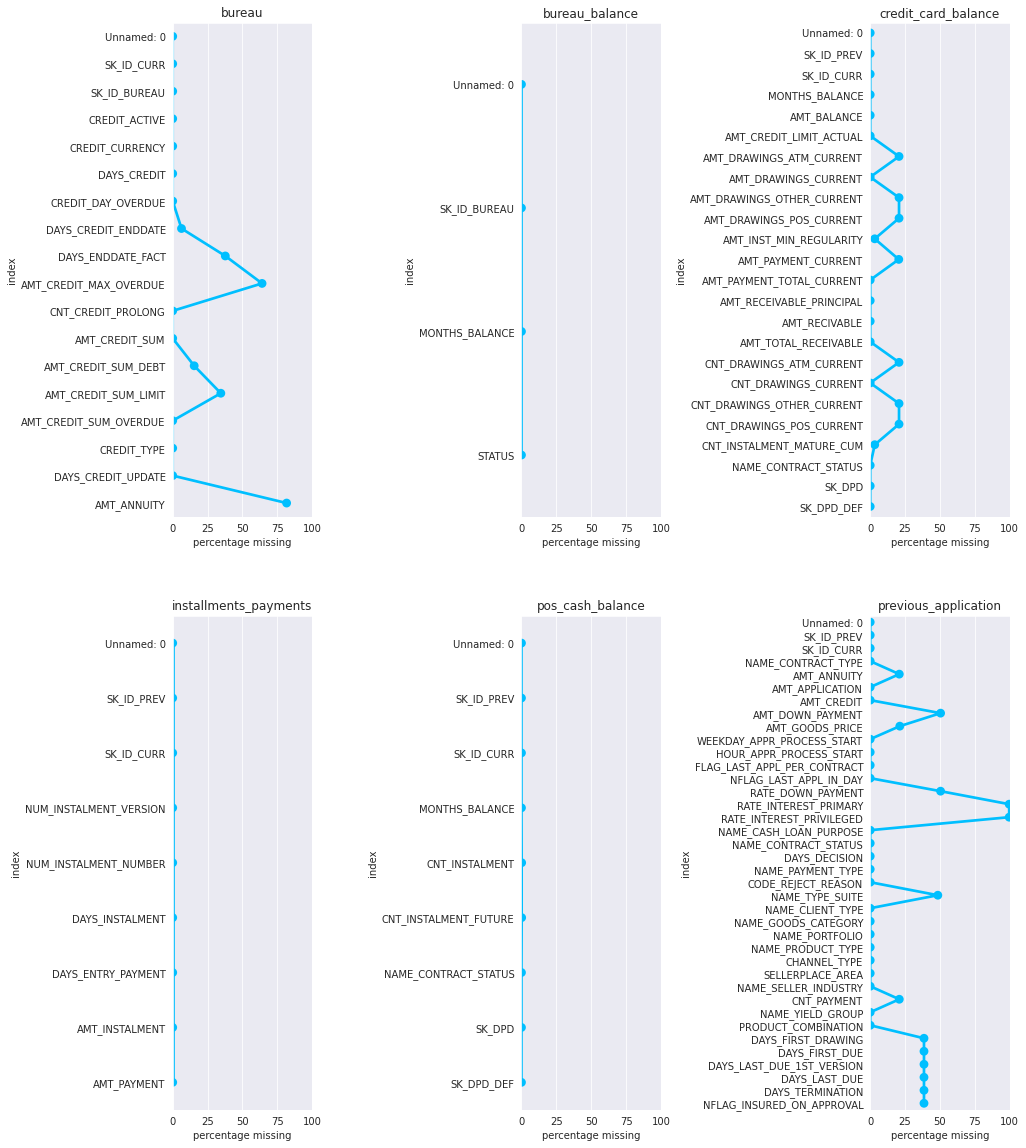

In [37]:
# Missing data in other data

plt.figure(figsize=(15,20))

plt.subplot(231)
sns.pointplot(0,"index",data=pd.DataFrame(bureau.isnull().sum()/bureau.shape[0]*100).reset_index(), color='deepskyblue')
plt.xlabel("percentage missing")
plt.xlim((0,100))
plt.title("bureau")

plt.subplot(232)
sns.pointplot(0,"index",data=pd.DataFrame(bureau_balance.isnull().sum()/bureau_balance.shape[0]*100).reset_index(), color='deepskyblue')
plt.xlabel("percentage missing")
plt.xlim((0,100))
plt.title("bureau_balance")

plt.subplot(233)
sns.pointplot(0,"index",data=pd.DataFrame(credit_card_balance.isnull().sum()/credit_card_balance.shape[0]*100).reset_index(), color='deepskyblue')
plt.xlabel("percentage missing")
plt.xlim((0,100))
plt.title("credit_card_balance")

plt.subplot(234)
sns.pointplot(0,"index",data=pd.DataFrame(installments_payments.isnull().sum()/installments_payments.shape[0]*100).reset_index(), color='deepskyblue')
plt.xlabel("percentage missing")
plt.xlim((0,100))
plt.title("installments_payments")

plt.subplot(235)
sns.pointplot(0,"index",data=pd.DataFrame(pos_cash_balance.isnull().sum()/pos_cash_balance.shape[0]*100).reset_index(), color='deepskyblue')
plt.xlabel("percentage missing")
plt.xlim((0,100))
plt.title("pos_cash_balance")

plt.subplot(236)
sns.pointplot(0,"index",data=pd.DataFrame(previous_application.isnull().sum()/previous_application.shape[0]*100).reset_index(), color='deepskyblue')
plt.xlabel("percentage missing")
plt.xlim((0,100))
plt.title("previous_application")

plt.subplots_adjust(wspace = 1.5)